In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torchmetrics import MeanAbsoluteError
from pytorch_lightning.loggers import CSVLogger
from ISLP.torch import SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers
from matplotlib.pyplot import subplots
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pytorch_lightning import seed_everything, Trainer

ModuleNotFoundError: No module named 'datamodule'

In [10]:
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

Seed set to 0


In [11]:
#pip install torchmetrics

In [12]:
#pip install pytorch-lightning 

In [13]:
#pip install ISLP

In [14]:
df = pd.read_csv('data/example_data.csv', delimiter = ',')

In [15]:
# Define categorical and numerical columns
categorical_cols = ['product_code', 'unit_of_measure', 'contract_type', 'buyer', 'supplier']
numerical_cols = ['quantity', 'total_value']
target_col = 'unit_price'  

# Use log_unit_price
df['log_unit_price'] = np.log(df[target_col])

# Preprocessing of columns
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])
X = preprocessor.fit_transform(df)
y = df['log_unit_price'].values

/opt/conda/lib/python3.12/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.12/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/conda/lib/python3.12/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [16]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# To torch tensors
X_train_t = torch.tensor(X_train.toarray() if hasattr(X_train, "toarray") else X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test.toarray() if hasattr(X_test, "toarray") else X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train.astype(np.float32))
y_test_t = torch.tensor(y_test.astype(np.float32))

# Tensor datasets
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

max_num_workers = rec_num_workers()
data_dm = SimpleDataModule(
    train_ds, test_ds, batch_size=32, 
    num_workers=min(4, max_num_workers), validation=test_ds
)

Define the MLP Model

In [17]:
class PharmaMLP(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

Training

In [18]:
model = PharmaMLP(X_train_t.shape[1])
module = SimpleModule.regression(model, metrics={'mae': MeanAbsoluteError()})

logger = CSVLogger('logs', name='pharma_price')
trainer = Trainer(
    deterministic=True,
    max_epochs=50,
    log_every_n_steps=5,
    logger=logger,
    callbacks=[ErrorTracker()],
    accelerator='gpu',       
    devices=1                 
)

trainer.fit(module, datamodule=data_dm)
trainer.test(module, datamodule=data_dm)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16-4Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | PharmaMLP | 3.1 K  | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │            nan            │
│         test_mae          │            nan            │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': nan, 'test_mae': nan}]

In [19]:
results = pd.read_csv(logger.experiment.metrics_file_path)

In [26]:
# Helper for the plot
def summary_plot(results,
                 ax,
                 train_col='train_mae_epoch',
                 valid_col='valid_mae',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='MAE',
                 fontsize=20):
    results.plot(x='epoch', y=train_col, label=training_legend, marker='o', color='black', ax=ax)
    results.plot(x='epoch', y=valid_col, label=valid_legend, marker='o', color='red', ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    ax.legend(fontsize=int(fontsize * 0.8))
    return ax

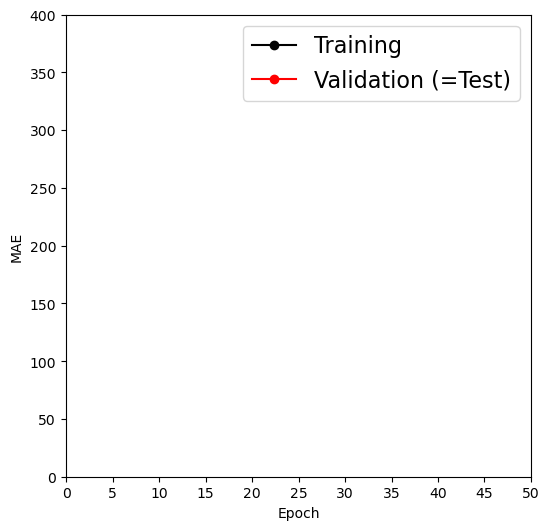

In [27]:
# Plot
fig, ax = subplots(1, 1, figsize=(6, 6))
ax = summary_plot(results, ax,
                  train_col='train_mae_epoch',
                  valid_col='valid_mae',
                  ylabel='MAE',
                  valid_legend='Validation (=Test)')
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, results['epoch'].max(), 11).astype(int));


Evaluation on Test set

In [33]:
def cross_validate_nn(X, y, k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=0)
    mae_scores, rmse_scores, r2_scores = [], [], []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f"Fold {fold + 1}/{k_folds}")
        
        # Split data
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # Convert to torch tensors
        X_train_t = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_t = torch.tensor(y_train_fold, dtype=torch.float32)
        X_val_t = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_t = torch.tensor(y_val_fold, dtype=torch.float32)
        
        # Create datasets and loaders
        train_ds = TensorDataset(X_train_t, y_train_t)
        val_ds = TensorDataset(X_val_t, y_val_t)
        train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
        
        # New model for each fold
        model = PharmaMLP(n_features=X.shape[1])
        module = SimpleModule.regression(model, metrics={'mae': MeanAbsoluteError()})

        trainer = Trainer(max_epochs=50, logger=False, enable_checkpointing=False)
        trainer.fit(module, train_loader, val_loader)

        # Collect predictions/targets for validation fold
        preds, targets = [], []
        for x_true, y_true in val_loader:
            with torch.no_grad():
                y_pred = model(x_true)
            preds.append(y_pred.detach().cpu().numpy())
            targets.append(y_true.detach().cpu().numpy())
        preds = np.concatenate(preds)
        targets = np.concatenate(targets)

        mae_scores.append(mean_absolute_error(targets, preds))
        rmse_scores.append(np.sqrt(mean_squared_error(targets, preds)))
        r2_scores.append(r2_score(targets, preds))
        
    print(f'MAE:  {np.mean(mae_scores):.3f} ± {np.std(mae_scores):.3f}')
    print(f'RMSE: {np.mean(rmse_scores):.3f} ± {np.std(rmse_scores):.3f}')
    print(f'R^2:  {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}')
    return mae_scores, rmse_scores, r2_scores


In [34]:
mae_scores, rmse_scores, r2_scores = cross_validate_nn(X, y, k_folds=5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | PharmaMLP | 3.1 K  | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Fold 1/5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ValueError: Input contains NaN.

In [30]:
model.eval()
with torch.no_grad():
    preds = model(X_test_t)

# Remove NaNs (maybe not needed)
# mask = ~torch.isnan(y_test_t) & ~torch.isnan(preds)
# filtered_y = y_test_t[mask]
# filtered_preds = preds[mask]

In [31]:
# Convert to numpy for sklearn metric
y_true = y_test_t.cpu().numpy()
y_pred = preds.cpu().numpy()

In [32]:
print(y_true)
print(y_pred)

[nan nan nan]
[nan nan nan]


In [33]:
# Compute Metrics

# MAE
mae = np.mean(np.abs(y_true - y_pred))
print('Test MAE:', mae)

# RMSE
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
print('Test RMSE:', rmse)

# R^2
r2 = r2_score(y_true, y_pred)
print('Test R^2:', r2)

Test MAE: nan
Test RMSE: nan


ValueError: Input contains NaN.